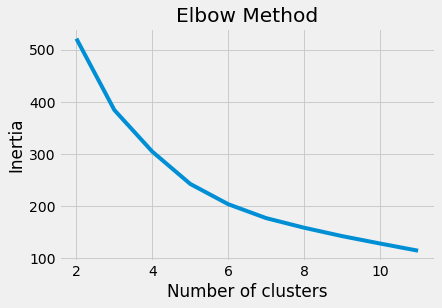

In [51]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

#Loading data
data = pd.read_csv('crypto_data.2022.2023.csv', index_col='Date', parse_dates=True)

#Drop NaN columns to remove cryptocoins that arent present for the whole period
data = data.dropna(axis=1)

#Split into training and test datasets
train_data = data.iloc[:183, :]
test_data = data.iloc[183:, :]

#Calculate daily returns
returns = train_data.pct_change().dropna()

#Creating features DataFrame
features = pd.DataFrame({
    'Mean_Return': returns.mean(),
    'Volatility': returns.std(),
})

#Calculating the Lowest_5% returns- Tail risk
average_values = {}
for column in returns.columns:
    column_sorted = returns[column].sort_values()
    threshold_index = int(len(column_sorted) * 0.05)
    threshold_value = column_sorted.iloc[threshold_index]
    lowest_5_percent = column_sorted[column_sorted <= threshold_value]
    average_values[column] = lowest_5_percent.mean()

features['Lowest_5%'] = features.index.map(average_values)

#Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

#Use elbow to find cluster numbers
inertia = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k).fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 12), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [36]:
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters).fit(scaled_features)
features['Cluster'] = kmeans.labels_

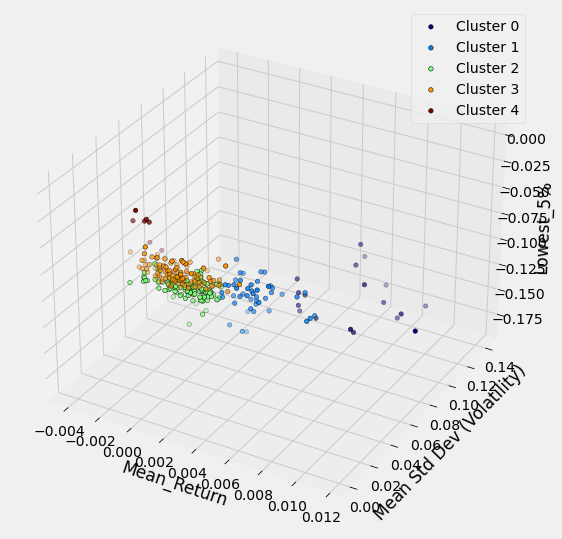

In [37]:
from mpl_toolkits.mplot3d import Axes3D

#Initialize 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

#Map colors
colors = plt.cm.jet(np.linspace(0, 1, len(set(features['Cluster']))))

#Loop through the clusters and plot them on a 3D scatter plot
for cluster, color in zip(set(features['Cluster']), colors):
    clustered_df = features[features['Cluster'] == cluster]
    ax.scatter(clustered_df['Mean_Return'],
               clustered_df['Volatility'],
               clustered_df['Lowest_5%'], 
               label=f'Cluster {cluster}', 
               c=[color]*len(clustered_df), 
               edgecolor='k')

#Set axis labels
ax.set_xlabel('Mean_Return')
ax.set_ylabel('Mean Std Dev (Volatility)')
ax.set_zlabel('Lowest_5%')
ax.legend()

#Show plot
plt.show()


In [38]:
cluster_stats = features
cluster_stats

,Mean_Return,Volatility,Lowest_5%,Cluster
BTCUSDT,0.000161,0.027881,-0.070244,3
ETHUSDT,0.000134,0.039010,-0.103576,3
BNBUSDT,0.000499,0.031747,-0.071367,3
NEOUSDT,-0.000644,0.036655,-0.097065,3
LTCUSDT,0.003430,0.040507,-0.088754,3
...,...,...,...,...
GALUSDT,-0.000653,0.056140,-0.120498,2
LDOUSDT,0.002307,0.073106,-0.142117,1
EPXUSDT,-0.001293,0.059966,-0.132901,2
OPUSDT,0.005836,0.074943,-0.138495,1


In [39]:
optimal_cluster = cluster_stats.loc[
    (cluster_stats['Lowest_5%'].idxmax()), 'Cluster']


In [40]:
optimal_cluster

4

In [41]:
selected_assets = features[features['Cluster'] == optimal_cluster]


In [42]:
selected_assets

,Mean_Return,Volatility,Lowest_5%,Cluster
TRXUSDT,-3.155615e-05,0.022016,-0.055917,4
FUNUSDT,-6.880076e-04,0.021043,-0.050309,4
BUSDUSDT,5.735929e-07,0.000220,-0.000273,4
EURUSDT,2.404277e-04,0.005745,-0.011991,4
GBPUSDT,-3.634482e-05,0.007973,-0.016737,4
PAXGUSDT,2.539586e-04,0.007889,-0.016362,4
GHSTUSDT,-9.405584e-04,0.010627,-0.022575,4


In [43]:
selected_returns = returns[selected_assets.index]


In [44]:
annual_rf_rate = 0.148
#Calculate daily risk-free rate using compounding
daily_rf_rate = np.exp(annual_rf_rate / 365) - 1

In [45]:
#Mean-variance optimization
def objective(weights, selected_assets, selected_returns): 
    portfolio_return = np.dot(weights, selected_assets['Mean_Return'])
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(selected_returns.cov(), weights)))
    return -((portfolio_return - daily_rf_rate) / portfolio_volatility)

#Initial optimization (Stage 1)
initial_guess = [1./len(selected_assets) for _ in selected_assets.index]
bounds = [(0, 1) for _ in selected_assets.index]
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
solution = minimize(objective, initial_guess, args=(selected_assets, selected_returns), bounds=bounds, constraints=constraints)
optimal_weights = pd.Series(solution.x, index=selected_assets.index)

#Filter out assets below a certain threshold (Stage 2)
threshold = 0.0  # Change this value based on your needs
above_threshold = optimal_weights > threshold
filtered_assets = optimal_weights.index[above_threshold]

#Re-run optimization with filtered assets
filtered_selected_assets = selected_assets.loc[filtered_assets]
filtered_selected_returns = selected_returns.loc[:, filtered_assets]
initial_guess = [1./len(filtered_assets) for _ in filtered_assets]
bounds = [(0, 1) for _ in filtered_assets]
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

filtered_solution = minimize(objective, initial_guess, args=(filtered_selected_assets, filtered_selected_returns), bounds=bounds, constraints=constraints)
filtered_optimal_weights = pd.Series(filtered_solution.x, index=filtered_assets)

print("Initial optimal weights:\n", optimal_weights)
print("Filtered optimal weights:\n", filtered_optimal_weights)


Initial optimal weights:
 TRXUSDT     1.000000e+00
FUNUSDT     9.107298e-17
BUSDUSDT    0.000000e+00
EURUSDT     0.000000e+00
GBPUSDT     4.943962e-17
PAXGUSDT    0.000000e+00
GHSTUSDT    1.647987e-17
dtype: float64
Filtered optimal weights:
 TRXUSDT     1.000000e+00
FUNUSDT     1.942890e-16
GBPUSDT     0.000000e+00
GHSTUSDT    4.163336e-17
dtype: float64


In [46]:
#Optimal asset weights
optimal_weights = pd.Series(filtered_solution.x, index=filtered_optimal_weights.index)

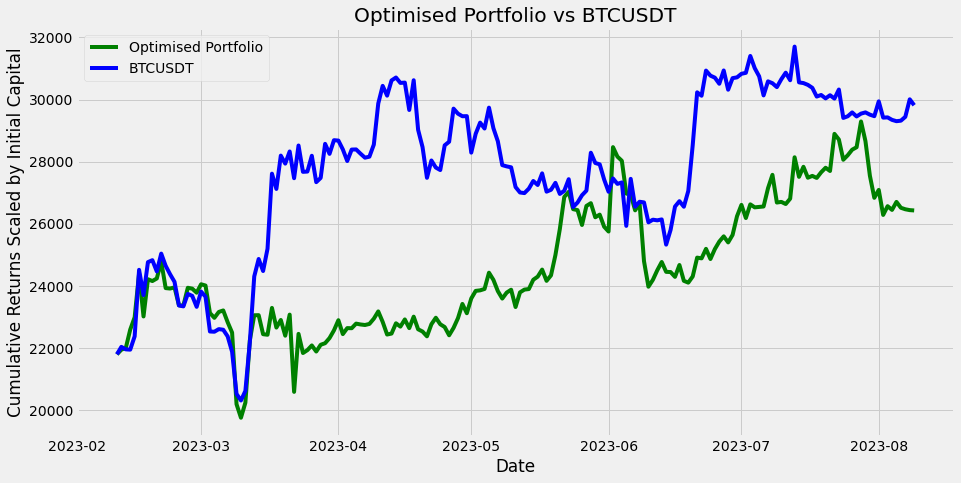

In [47]:
#Calculate the portfolio returns for the test period
test_returns = test_data[filtered_optimal_weights.index].pct_change().dropna()
portfolio_test_returns = (filtered_optimal_weights * test_returns).sum(axis=1)

#Get the initial price of BTCUSDT
initial_btc_price = test_data['BTCUSDT'].iloc[0]

#Align the first return to be zero
portfolio_test_returns.iloc[0] = 0
btc_test_returns = test_data['BTCUSDT'].pct_change().dropna()
btc_test_returns.iloc[0] = 0

#Calculate the scaled returns
scaled_portfolio_returns = (1 + portfolio_test_returns).cumprod() * initial_btc_price
scaled_btc_returns = (1 + btc_test_returns).cumprod() * initial_btc_price

#Plotting
plt.figure(figsize=(14, 7))
plt.plot(scaled_portfolio_returns, label='Optimised Portfolio', color='g')
plt.plot(scaled_btc_returns, label='BTCUSDT', color='b')
plt.title('Optimised Portfolio vs BTCUSDT')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns Scaled by Initial Capital')
plt.legend()
plt.show()


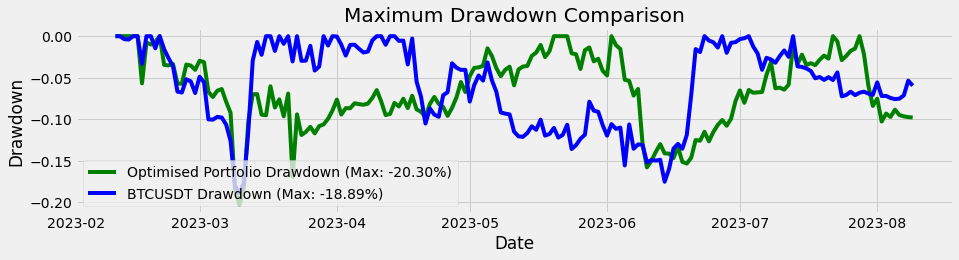

Maximum Drawdown for Optimised Portfolio: -20.30%
Maximum Drawdown for BTCUSDT: -18.89%


In [48]:
#Function to calculate drawdowns
def calculate_drawdowns(return_series):
    #Calculate the running maximum
    running_max = return_series.cummax()
    #Ensure the value never drops below the initial capital
    running_max[running_max < return_series.iloc[0]] = return_series.iloc[0]
    #Calculate the percentage drawdown
    drawdown = (return_series / running_max) - 1
    return drawdown

#Calculating drawdowns for portfolio and BTCUSDT
portfolio_drawdown = calculate_drawdowns(scaled_portfolio_returns)
btcusdt_drawdown = calculate_drawdowns(scaled_btc_returns)

#Calculating max drawdowns in percentages for portfolio and BTCUSDT
max_drawdown_portfolio = portfolio_drawdown.min() * 100
max_drawdown_btcusdt = btcusdt_drawdown.min() * 100

#Calculate the Sharpe ratio for both series
#Assuming daily risk-free rate same as before
portfolio_sharpe_ratio = (portfolio_test_returns.mean() - daily_rf_rate) / portfolio_test_returns.std()
btcusdt_sharpe_ratio = (btc_test_returns.mean() - daily_rf_rate) / btc_test_returns.std()

#Plotting the results
#Drawdown Comparison
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(portfolio_drawdown.index, portfolio_drawdown, label=f"Optimised Portfolio Drawdown (Max: {max_drawdown_portfolio:.2f}%)", color='g')
plt.plot(btcusdt_drawdown.index, btcusdt_drawdown, label=f"BTCUSDT Drawdown (Max: {max_drawdown_btcusdt:.2f}%)", color='b')
plt.title('Maximum Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.show()

print(f"Maximum Drawdown for Optimised Portfolio: {max_drawdown_portfolio:.2f}%")
print(f"Maximum Drawdown for BTCUSDT: {max_drawdown_btcusdt:.2f}%")


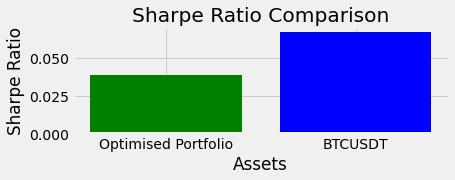

In [49]:
#Sharpe Ratio Comparison
plt.subplot(2, 1, 2)
plt.bar(['Optimised Portfolio', 'BTCUSDT'], [portfolio_sharpe_ratio, btcusdt_sharpe_ratio], color=['g', 'b'])
plt.title('Sharpe Ratio Comparison')
plt.xlabel('Assets')
plt.ylabel('Sharpe Ratio')
plt.show()

In [50]:
#Calculate the total returns for the portfolio and BTCUSDT
final_portfolio_value = scaled_portfolio_returns.iloc[-1]
initial_portfolio_value = scaled_portfolio_returns.iloc[0]
total_portfolio_return = (final_portfolio_value / initial_portfolio_value) - 1

final_btc_value = scaled_btc_returns.iloc[-1]
initial_btc_value = scaled_btc_returns.iloc[0]
total_btc_return = (final_btc_value / initial_btc_value) - 1

print(f"Total Portfolio Return: {total_portfolio_return * 100:.2f}%")
print(f"Total BTCUSDT Return: {total_btc_return * 100:.2f}%")


Total Portfolio Return: 21.25%
Total BTCUSDT Return: 36.79%
